In [17]:
# import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# read the data
path = "../Datasets/"
train = pd.read_csv(path + '/Historical-transaction-data.csv')
storeInfo = pd.read_csv(path + '/Store-info.csv')
test = pd.read_csv(path + '/Testing-data.csv')

# merge the data
train = train.merge(storeInfo, on='shop_id', how='left')
storeInfo.drop("shop_profile", axis=1, inplace=True)

train_cp = train.drop("shop_profile", axis=1)
test = test.merge(train_cp, on='shop_id', how='left')
test.drop("shop_profile", axis=1, inplace=True)

# explore the test data
# print first few rows of the data frame
print(test.head())

# print summary statistics of the numerical columns
print(test.describe())

# print information about the data frame
print(test.info())

   shop_id         item_description          transaction_date  invoice_id  \
0  SHOP046     FIT O MIXED FRUIT 1L  2021-10-15T00:00:00.000Z    154826.0   
1  SHOP046          FIT O ORANGE 1L  2021-10-27T00:00:00.000Z    157798.0   
2  SHOP046            LEMONADE 1.5L  2021-10-28T00:00:00.000Z    157881.0   
3  SHOP046        FIT O MANGO 200ML  2021-11-03T00:00:00.000Z    159352.0   
4  SHOP046  FIT O MIXED FRUIT 200ML  2021-11-03T00:00:00.000Z    159352.0   

  customer_id  item_price  quantity_sold  shop_area_sq_ft  
0        H6RV         270              1              545  
1        Z1SZ         290              1              545  
2        HFM8         220              2              545  
3        RFTZ         180              4              545  
4        RFTZ          60              1              545  
         invoice_id    item_price  quantity_sold  shop_area_sq_ft
count  8.575000e+04  86633.000000   86633.000000     86633.000000
mean   1.924426e+06    213.862904       1.937

In [18]:
# clean the data
def clean_data(df):
    # remove duplicates
    df.drop_duplicates(inplace=True)
    # remove missing values
    df.dropna(inplace=True)
    # remove outliers
    Q1 = df['item_price'].quantile(0.25)
    Q3 = df['item_price'].quantile(0.75)
    IQR = Q3 - Q1
    df = df[(df['item_price'] >= Q1 - 1.5*IQR) & (df['item_price'] <= Q3 + 1.5*IQR)]
    return df

# clean the data
train = clean_data(train)
test = clean_data(test)


In [19]:
# preprocess the data
def preprocess(df):
    # convert categorical variables into numerical variables
    df['item_description'] = df['item_description'].astype('category')
    df['customer_id'] = df['customer_id'].astype('category')
    df['shop_id'] = df['shop_id'].str.replace("SHOP", "").astype(int)

    # convert transaction_date into datetime format
    df['transaction_date'] = pd.to_datetime(df['transaction_date'])
    
    # create new features as year, month, day, and weekday
    df['year'] = df['transaction_date'].dt.year
    df['month'] = df['transaction_date'].dt.month
    df['day'] = df['transaction_date'].dt.day
    df['weekday'] = df['transaction_date'].dt.weekday

    # transform categorical variables into numerical variables
    df['item_description'] = df['item_description'].cat.codes
    df['customer_id'] = df['customer_id'].cat.codes

    # drop transaction_date column
    df.drop('transaction_date', axis=1, inplace=True)

    # drop invoice_id column
    df.drop('invoice_id', axis=1, inplace=True)

    return df

# preprocess the train data
train = preprocess(train)

# preprocess the test data
test = preprocess(test)


## Feature Engineering and Selection
We can use feature engineering and selection techniques to identify the most relevant features for our model. Some common techniques are:

1. Correlation matrix: Identify the features with the highest correlation with the target variable.
2. Recursive Feature Elimination (RFE): Use a machine learning model to recursively eliminate the least important features.
3. Principal Component Analysis (PCA): Reduce the dimensionality of the data by transforming the features into a lower-dimensional space.

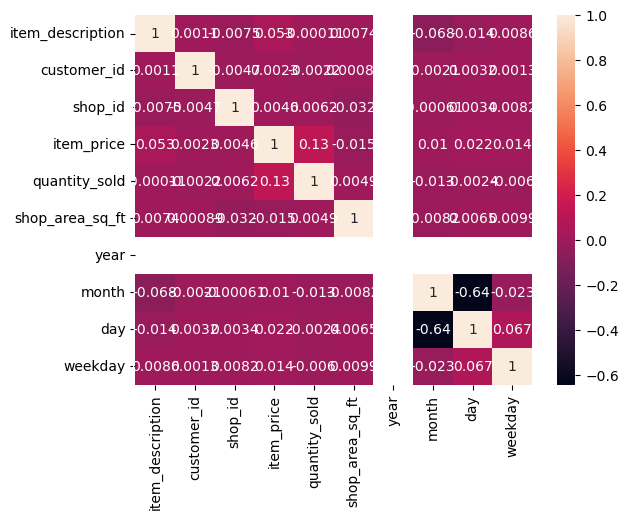

In [20]:
# correlation matrix
corr_matrix = train.corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()

# recursive feature elimination
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor

y = train['shop_profile']
X = train.drop('shop_profile', axis=1)

# label encode the target variable
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

## Model Selection and Training
We can use various machine learning models to predict the target variable (total revenue) based on the selected features. Some common models are:

1. Linear Regression
2. Decision Trees
3. Random Forests
4. Gradient Boosting

In [21]:
# split the data into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# decision trees
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)

# random forest
rf = RandomForestRegressor()
rf.fit(X_train, y_train)


RandomForestRegressor()

In [ ]:
model = RandomForestRegressor()
rfe = RFE(model, n_features_to_select=5)
rfe.fit(X, y)

selected_features = X.columns[rfe.support_]

# principal component analysis
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)

## Evaluate and Optimize the Model
Once we have trained the models, we need to evaluate their performance and optimize them if necessary. We can use various metrics to evaluate the model, such as:

1. Accuracy Score
2. Precision Score
3. Recall Score
4. F1 Score (F1)

In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# evaluate decision trees
dt_pred = dt.predict(X_test).astype(int)
dt_accuracy = accuracy_score(dt_pred, y_test)
dt_precision = precision_score(dt_pred, y_test,  average='macro')
dt_recall = recall_score(dt_pred, y_test,  average='macro')
dt_f1 = f1_score(dt_pred, y_test,  average='macro')
print(f'Decision Trees: Accuracy={dt_accuracy:.2f}, Precision={dt_precision:.2f}, Recall={dt_recall:.2f}, F1={dt_f1:.2f}')

# evaluate random forest
rf_pred = rf.predict(X_test).astype(int)
rf_accuracy = accuracy_score(rf_pred, y_test)
rf_precision = precision_score(rf_pred, y_test,  average='macro')
rf_recall = recall_score(rf_pred, y_test,  average='macro')
rf_f1 = f1_score(rf_pred, y_test,  average='macro')
print(f'Random Forest: Accuracy={rf_accuracy:.2f}, Precision={rf_precision:.2f}, Recall={rf_recall:.2f}, F1={rf_f1:.2f}')



Decision Trees: Accuracy=1.00, Precision=1.00, Recall=1.00, F1=1.00
Random Forest: Accuracy=1.00, Precision=1.00, Recall=1.00, F1=1.00


In [23]:
print(test.info())

# predict the test data and save it to a csv file with shop_id and shop_profile columns with only unique shop_id values
test_pred = dt.predict(test).astype(int)
test_pred = le.inverse_transform(test_pred)

test_pred = pd.DataFrame({'shop_id': 'SHOP' + test['shop_id'].astype('str').str.zfill(3), 'shop_profile': test_pred})
test_pred = test_pred.drop_duplicates(subset='shop_id', keep='first')

# save the submission file
test_pred.to_csv('submission.csv', index=False)

# print the first few rows of the submission file
print(test_pred.head())



<class 'pandas.core.frame.DataFrame'>
Int64Index: 65982 entries, 0 to 86632
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   shop_id           65982 non-null  int32
 1   item_description  65982 non-null  int8 
 2   customer_id       65982 non-null  int32
 3   item_price        65982 non-null  int64
 4   quantity_sold     65982 non-null  int64
 5   shop_area_sq_ft   65982 non-null  int64
 6   year              65982 non-null  int64
 7   month             65982 non-null  int64
 8   day               65982 non-null  int64
 9   weekday           65982 non-null  int64
dtypes: int32(2), int64(7), int8(1)
memory usage: 4.6 MB
None
       shop_id shop_profile
0      SHOP046         High
3438   SHOP024         High
6321   SHOP023         High
10426  SHOP097     Moderate
13572  SHOP044         High


c:\Users\ROG\anaconda3\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
